In [1]:
import torch
import torch.nn as nn
import pandas as pd
import ta
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from torch.ao.nn.quantized.functional import conv2d
from torch.multiprocessing import start_processes
from torch.utils.data import Dataset, DataLoader


def process(df,TARGET_COL,LOOKBACK,BATCH_SIZE,HIDDEN_SIZE,CONV1_SIZE,NUM_LAYERS,OUTPUT_SIZE,EPOCHES,target_value):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    #df['RSI'] = ta.momentum.RSIIndicator(df['close'],window=50,fillna=False).rsi()
    #df['kama'] = ta.momentum.kama(df['close'],window=14,fillna=False)
    #df['adx'] = ta.trend.ADXIndicator(df['high'],df['low'],df['close'],window=14,fillna=False).adx()
    #df['obv'] = ta.volume.OnBalanceVolumeIndicator(close=df['close'], volume=df['tick_volume']).on_balance_volume()
    #df['cmf'] = ta.volume.ChaikinMoneyFlowIndicator(high=df['high'],low=df['low'],close=df['close'],volume=df['tick_volume'],window=20).chaikin_money_flow()
    #boll = ta.volatility.BollingerBands(close=df['close'], window=20, window_dev=2)
    #df['BB_High'] = boll.bollinger_hband()
    #df['BB_Low'] = boll.bollinger_lband()
    #df['BB_Mid'] = boll.bollinger_mavg()
    #df['EMA_10'] = ta.trend.EMAIndicator(close=df['close'], window=10).ema_indicator()
    #df['EMA_50'] = ta.trend.EMAIndicator(close=df['close'], window=50).ema_indicator()
    df['LOG'] = np.log(df['close'] / df['close'].shift(1))
    df['PCTC'] = df['close'].pct_change()
    df['HLD'] = df['high'] - df['low']
    df['OCD'] = df['close'] - df['open']

    df = df.bfill()

    features = df.columns.tolist()

    scaler = StandardScaler()
    scaled_df = scaler.fit_transform(df)

    def create_dataset(data):
        X,y = [],[]
        for i in range(len(data) - LOOKBACK - 1):
            X.append(data[i:(i + LOOKBACK), :])  # Take all columns
            y.append(data[i + LOOKBACK, TARGET_COL])

        return np.array(X), np.array(y)

    X,y = create_dataset(scaled_df)

    X_train, X_test = train_test_split(X, test_size=0.2, shuffle=False)  # shuffle=False for time series
    y_train, y_test = train_test_split(y, test_size=0.2, shuffle=False)  # shuffle=False for time series

    X_train = torch.tensor(X_train).to(device)
    y_train = torch.tensor(y_train).to(device)
    X_test = torch.tensor(X_test).to(device)
    y_test = torch.tensor(y_test).to(device)

    class StockDataset(Dataset):
        def __init__(self, features, targets):
            self.features = features
            self.targets = targets

        def __len__(self):
            return len(self.features)

        def __getitem__(self, idx):
            return self.features[idx], self.targets[idx]

    train_dataset = StockDataset(X_train, y_train)
    test_dataset = StockDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

    class LSTM(nn.Module):
        def __init__(self, input_size, hidden_size,conv_channels, output_size, num_layers, dropout = 0.0, kernel_size = 3):
            super(LSTM, self).__init__()
            self.hidden_size = hidden_size
            self.num_layers = num_layers

            # CNN layer for feature extraction
            self.conv1d = nn.Conv1d(in_channels=input_size, out_channels=conv_channels, kernel_size=3, padding=1)

            # LSTM layer for temporal modeling
            self.lstm = nn.LSTM(conv_channels, hidden_size, num_layers, batch_first=True)

            # Fully connected layer for output
            self.fc = nn.Linear(hidden_size, output_size)

        def forward(self, x):
            # Apply CNN to the input (batch_size, sequence_length, features)
            x = x.permute(0, 2, 1) # Reshape for Conv1d
            x = self.conv1d(x)
            x = x.permute(0, 2, 1) # Reshape back for LSTM

            # Pass through LSTM
            h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
            c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
            out, _ = self.lstm(x, (h_0, c_0))

            # Take the output from the last time step and pass to the linear layer
            out = self.fc(out[:, -1, :])
            return out

    num_features = scaled_df.shape[1]
    model = LSTM(input_size=num_features, hidden_size=HIDDEN_SIZE, conv_channels=CONV1_SIZE,output_size=OUTPUT_SIZE,num_layers=NUM_LAYERS).to(device)
    from torch import optim

    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    criterion = nn.MSELoss()
    running_loss = 0.0
    avg_train_loss = 0.0

    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        for x_batch, y_batch in train_loader:

            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()

            y_pred = model(x_batch.float())
            loss = criterion(y_pred.flatten(), y_batch.float())

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_train_loss:.5f}")

    model.eval()

    predictions = []
    actuals = []

    running_loss = 0.0
    avg_test_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(x_batch.float())
            predictions.extend(y_pred.flatten().cpu().numpy())
            actuals.extend(y_batch.flatten().cpu().numpy())
            loss = criterion(y_pred.flatten(), y_batch.float())
            running_loss += loss.item()
        avg_test_loss = running_loss / len(test_loader)
        print(f"Loss: {avg_test_loss:.5f}")

        predictions = np.array(predictions)

    actuals = np.array(actuals)

    def inverse_close(scaled_close):
        dummy = np.zeros((scaled_close.shape[0], len(features)))
        dummy[:, TARGET_COL] = scaled_close
        return scaler.inverse_transform(dummy)[:, TARGET_COL]

    actual_prices = inverse_close(actuals.flatten())
    pred_prices_test = inverse_close(predictions.flatten())


    # Plot predictions vs real values
    plt.figure(figsize=(10,5))
    plt.plot(actual_prices[-10:], label="Real")
    plt.plot(pred_prices_test[-10:], label="Predicted")
    plt.legend()
    plt.title("Test Results: Real vs Predicted")
    plt.show()
    last_seq = scaled_df[-LOOKBACK:]
    input_seq = torch.tensor(last_seq, dtype=torch.float32).unsqueeze(0).to(device)

    print(last_seq.shape)
    model.eval()

    with torch.no_grad():
        next_scaled = model(input_seq.float())
        next_scaled = next_scaled.item()

    dummy = np.zeros((1, scaled_df.shape[1]))
    dummy[0, TARGET_COL] = next_scaled  # put predicted scaled value in target column
    next_pred = scaler.inverse_transform(dummy)[0, TARGET_COL]

    print("Last Close", df.iloc[-1, TARGET_COL])
    print("Next predicted value:", next_pred)
    print("Next real value:", target_value)
    print("Risidual:", next_pred - target_value)
    data = {
        'last_close': df.iloc[-1, TARGET_COL],
        'predict':next_pred,
        'target_value':target_value,
        'residual': next_pred-target_value,
        'train_loss': avg_train_loss,
        'test_loss': avg_test_loss,
        'LOOKBACK':LOOKBACK,
        'BATCH_SIZE':BATCH_SIZE,
        'HIDDEN_SIZE':HIDDEN_SIZE,
        'CONV1_SIZE':CONV1_SIZE,
        'NUM_LAYERS':NUM_LAYERS,
        'OUTPUT_SIZE':OUTPUT_SIZE,
        'EPOCHS':EPOCHS,
    }
    return data





=== Training with HIDDEN_SIZE=64, conv1_size=32, batch_size=8, num_layers=1 ===
Epoch 1/10, Loss: 0.00358
Epoch 2/10, Loss: 0.00051
Epoch 3/10, Loss: 0.00051
Epoch 4/10, Loss: 0.00047
Epoch 5/10, Loss: 0.00045
Epoch 6/10, Loss: 0.00045
Epoch 7/10, Loss: 0.00044
Epoch 8/10, Loss: 0.00044
Epoch 9/10, Loss: 0.00043
Epoch 10/10, Loss: 0.00043
Loss: 0.00040


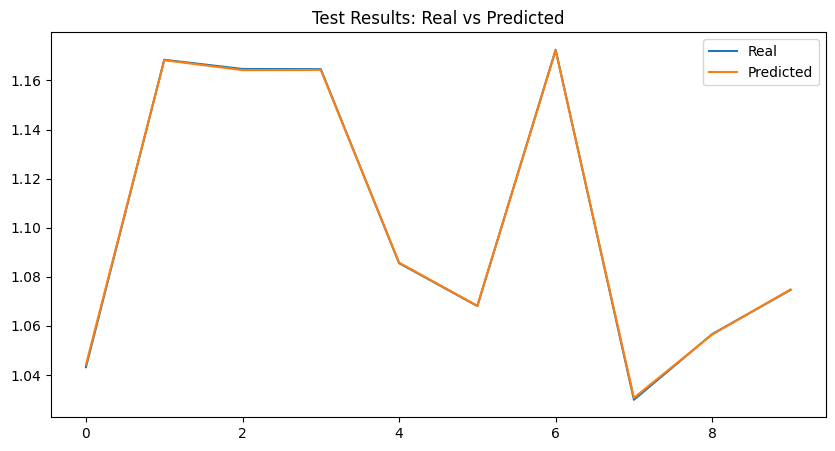

(120, 11)
Last Close 1.15878
Next predicted value: 1.1584165990140431
Next real value: 1.15981
Risidual: -0.0013934009859568608

=== Training with HIDDEN_SIZE=64, conv1_size=32, batch_size=8, num_layers=2 ===
Epoch 1/10, Loss: 0.00515
Epoch 2/10, Loss: 0.00052
Epoch 3/10, Loss: 0.00049
Epoch 4/10, Loss: 0.00048
Epoch 5/10, Loss: 0.00047
Epoch 6/10, Loss: 0.00046
Epoch 7/10, Loss: 0.00046
Epoch 8/10, Loss: 0.00045
Epoch 9/10, Loss: 0.00044
Epoch 10/10, Loss: 0.00044
Loss: 0.00036


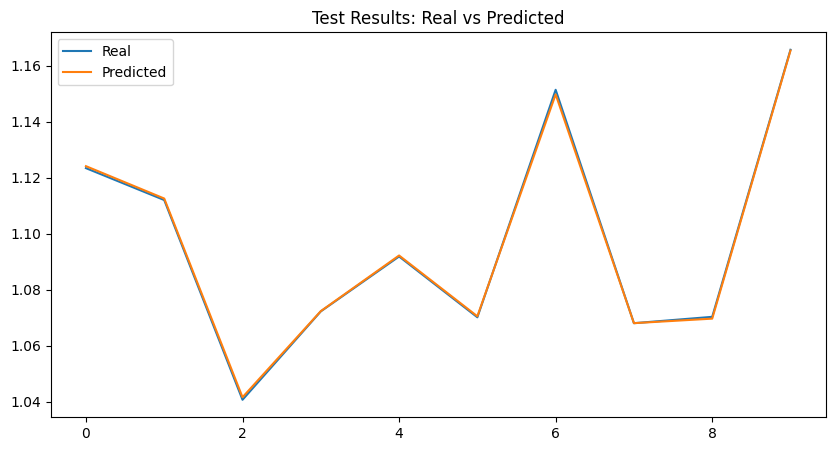

(120, 11)
Last Close 1.15878
Next predicted value: 1.1587652928305336
Next real value: 1.15981
Risidual: -0.0010447071694663634

=== Training with HIDDEN_SIZE=64, conv1_size=32, batch_size=8, num_layers=3 ===
Epoch 1/10, Loss: 0.00936
Epoch 2/10, Loss: 0.00063
Epoch 3/10, Loss: 0.00055
Epoch 4/10, Loss: 0.00052
Epoch 5/10, Loss: 0.00052
Epoch 6/10, Loss: 0.00050
Epoch 7/10, Loss: 0.00049
Epoch 8/10, Loss: 0.00048
Epoch 9/10, Loss: 0.00048
Epoch 10/10, Loss: 0.00049
Loss: 0.00038


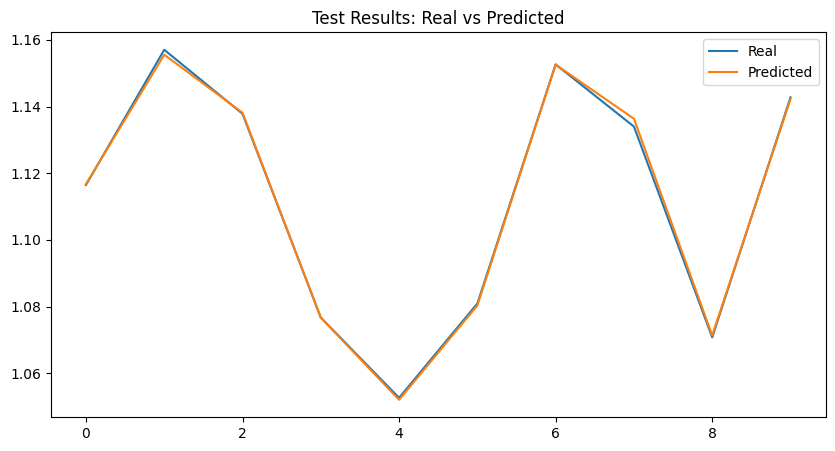

(120, 11)
Last Close 1.15878
Next predicted value: 1.1588330107805092
Next real value: 1.15981
Risidual: -0.0009769892194908536

=== Training with HIDDEN_SIZE=64, conv1_size=32, batch_size=8, num_layers=4 ===
Epoch 1/10, Loss: 0.02129
Epoch 2/10, Loss: 0.00074
Epoch 3/10, Loss: 0.00067
Epoch 4/10, Loss: 0.00062
Epoch 5/10, Loss: 0.00059
Epoch 6/10, Loss: 0.00056
Epoch 7/10, Loss: 0.00054
Epoch 8/10, Loss: 0.00053
Epoch 9/10, Loss: 0.00053
Epoch 10/10, Loss: 0.00053
Loss: 0.00039


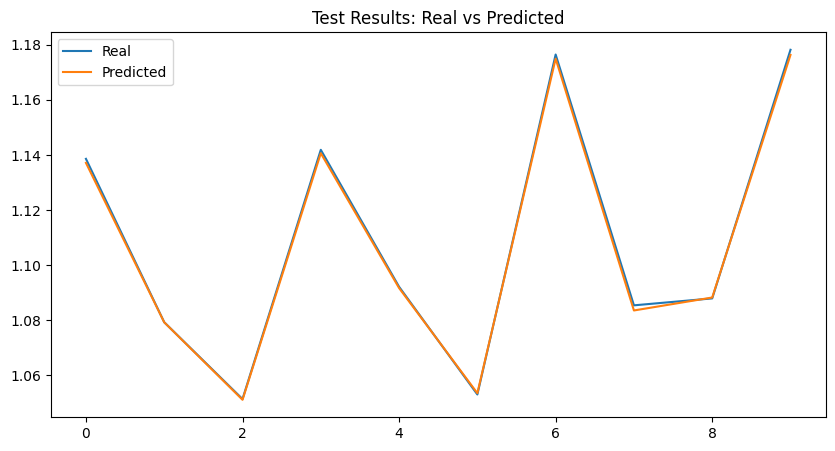

(120, 11)
Last Close 1.15878
Next predicted value: 1.158049458572747
Next real value: 1.15981
Risidual: -0.001760541427253015

=== Training with HIDDEN_SIZE=64, conv1_size=32, batch_size=8, num_layers=5 ===
Epoch 1/10, Loss: 0.03950
Epoch 2/10, Loss: 0.00095
Epoch 3/10, Loss: 0.00078
Epoch 4/10, Loss: 0.00072
Epoch 5/10, Loss: 0.00070
Epoch 6/10, Loss: 0.00066
Epoch 7/10, Loss: 0.00060
Epoch 8/10, Loss: 0.00060
Epoch 9/10, Loss: 0.00058
Epoch 10/10, Loss: 0.00057
Loss: 0.00041


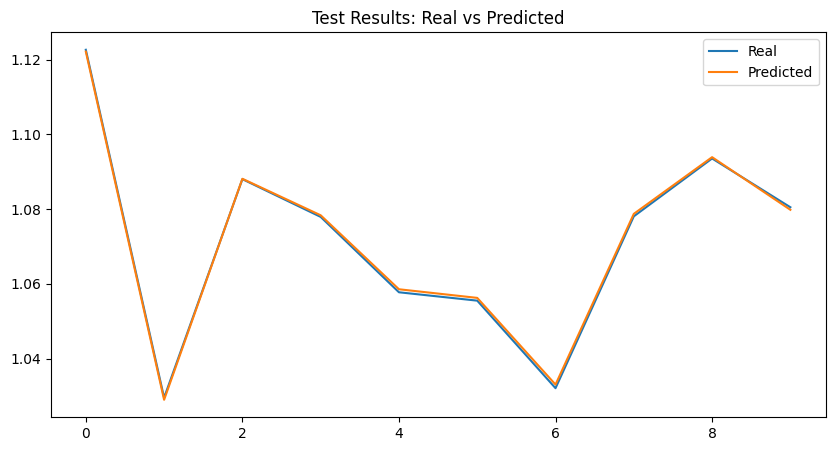

(120, 11)
Last Close 1.15878
Next predicted value: 1.1581274027748913
Next real value: 1.15981
Risidual: -0.0016825972251086618

=== Training with HIDDEN_SIZE=64, conv1_size=32, batch_size=8, num_layers=6 ===
Epoch 1/10, Loss: 0.17905
Epoch 2/10, Loss: 0.00136
Epoch 3/10, Loss: 0.00111
Epoch 4/10, Loss: 0.00093
Epoch 5/10, Loss: 0.00080
Epoch 6/10, Loss: 0.00077
Epoch 7/10, Loss: 0.00073
Epoch 8/10, Loss: 0.00067
Epoch 9/10, Loss: 0.00066
Epoch 10/10, Loss: 0.00064
Loss: 0.00056


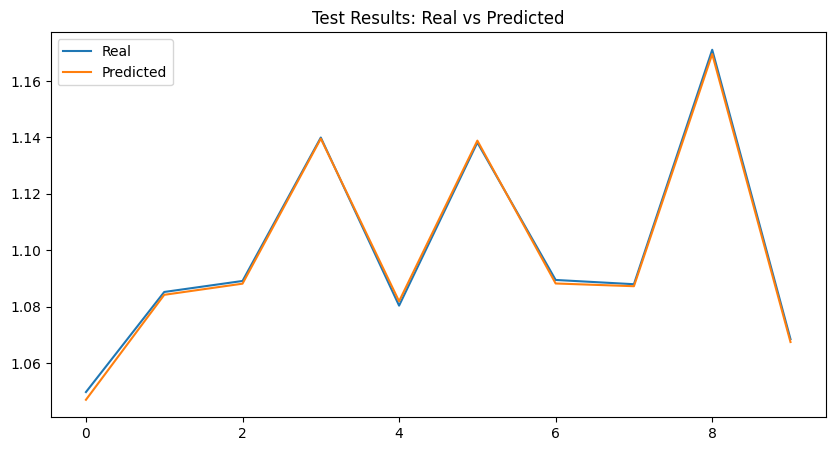

(120, 11)
Last Close 1.15878
Next predicted value: 1.1580870543893007
Next real value: 1.15981
Risidual: -0.0017229456106993002

=== Training with HIDDEN_SIZE=64, conv1_size=32, batch_size=16, num_layers=1 ===
Epoch 1/10, Loss: 0.00463
Epoch 2/10, Loss: 0.00050
Epoch 3/10, Loss: 0.00045
Epoch 4/10, Loss: 0.00044
Epoch 5/10, Loss: 0.00043
Epoch 6/10, Loss: 0.00042
Epoch 7/10, Loss: 0.00041
Epoch 8/10, Loss: 0.00042
Epoch 9/10, Loss: 0.00041
Epoch 10/10, Loss: 0.00041
Loss: 0.00043


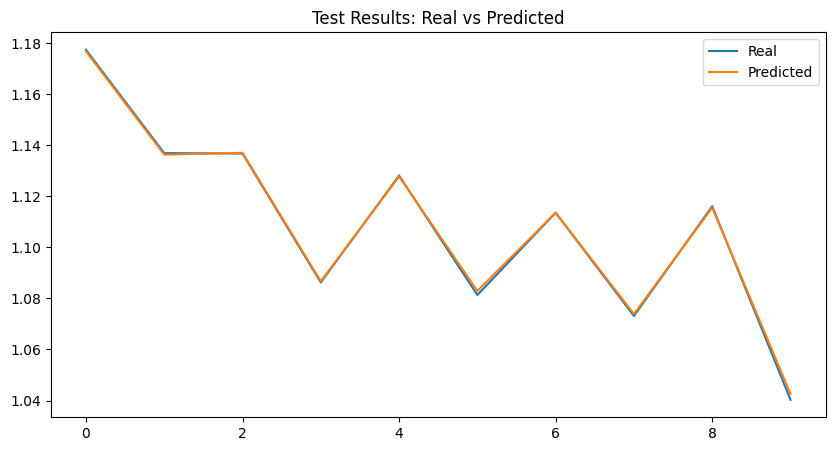

(120, 11)
Last Close 1.15878
Next predicted value: 1.1583711867159943
Next real value: 1.15981
Risidual: -0.0014388132840057466

=== Training with HIDDEN_SIZE=64, conv1_size=32, batch_size=16, num_layers=2 ===
Epoch 1/10, Loss: 0.00987
Epoch 2/10, Loss: 0.00050
Epoch 3/10, Loss: 0.00048
Epoch 4/10, Loss: 0.00046
Epoch 5/10, Loss: 0.00045
Epoch 6/10, Loss: 0.00043
Epoch 7/10, Loss: 0.00044
Epoch 8/10, Loss: 0.00043
Epoch 9/10, Loss: 0.00042
Epoch 10/10, Loss: 0.00043
Loss: 0.00043


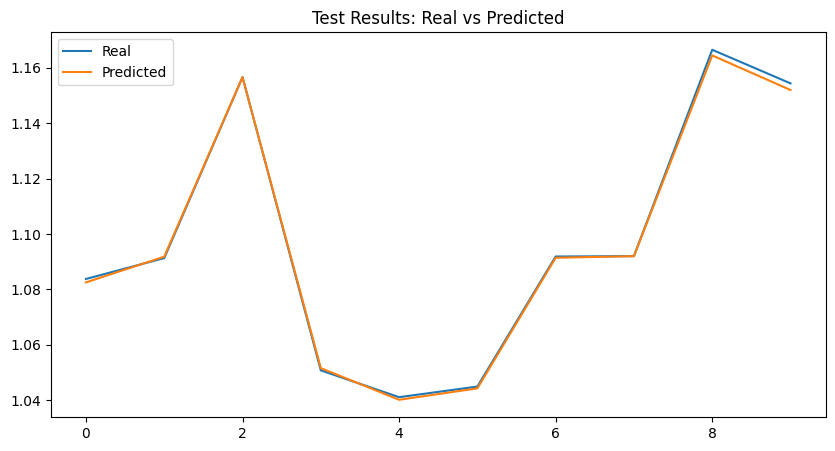

(120, 11)
Last Close 1.15878
Next predicted value: 1.1580810299626163
Next real value: 1.15981
Risidual: -0.0017289700373837036

=== Training with HIDDEN_SIZE=64, conv1_size=32, batch_size=16, num_layers=3 ===
Epoch 1/10, Loss: 0.01895
Epoch 2/10, Loss: 0.00055
Epoch 3/10, Loss: 0.00051
Epoch 4/10, Loss: 0.00049
Epoch 5/10, Loss: 0.00049
Epoch 6/10, Loss: 0.00047
Epoch 7/10, Loss: 0.00046
Epoch 8/10, Loss: 0.00046
Epoch 9/10, Loss: 0.00046
Epoch 10/10, Loss: 0.00045
Loss: 0.00050


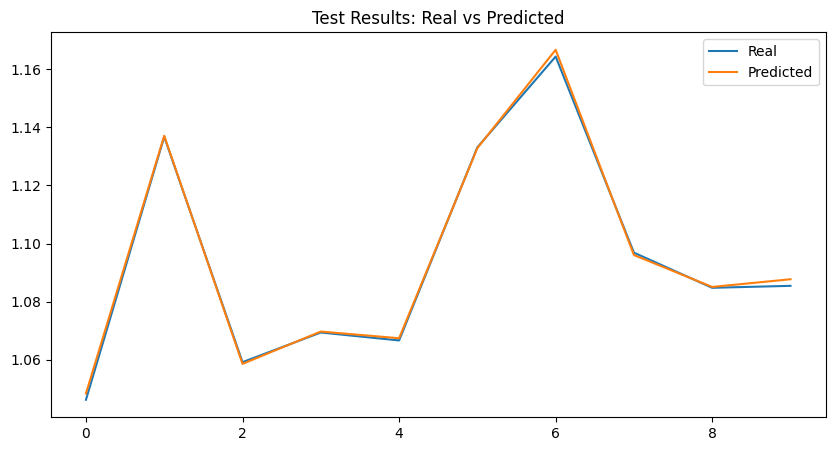

(120, 11)
Last Close 1.15878
Next predicted value: 1.1587435438016924
Next real value: 1.15981
Risidual: -0.001066456198307586

=== Training with HIDDEN_SIZE=64, conv1_size=32, batch_size=16, num_layers=4 ===
Epoch 1/10, Loss: 0.04184
Epoch 2/10, Loss: 0.00072
Epoch 3/10, Loss: 0.00064
Epoch 4/10, Loss: 0.00058
Epoch 5/10, Loss: 0.00057
Epoch 6/10, Loss: 0.00056
Epoch 7/10, Loss: 0.00053
Epoch 8/10, Loss: 0.00052
Epoch 9/10, Loss: 0.00050
Epoch 10/10, Loss: 0.00050
Loss: 0.00094


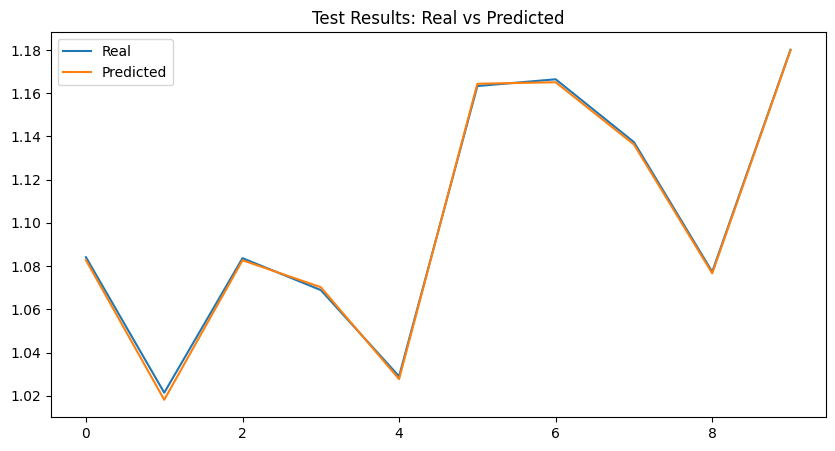

(120, 11)
Last Close 1.15878
Next predicted value: 1.1573904915088176
Next real value: 1.15981
Risidual: -0.0024195084911824427

=== Training with HIDDEN_SIZE=64, conv1_size=32, batch_size=16, num_layers=5 ===
Epoch 1/10, Loss: 0.06568
Epoch 2/10, Loss: 0.00094
Epoch 3/10, Loss: 0.00081
Epoch 4/10, Loss: 0.00073
Epoch 5/10, Loss: 0.00069
Epoch 6/10, Loss: 0.00065
Epoch 7/10, Loss: 0.00060
Epoch 8/10, Loss: 0.00058
Epoch 9/10, Loss: 0.00058
Epoch 10/10, Loss: 0.00057
Loss: 0.00046


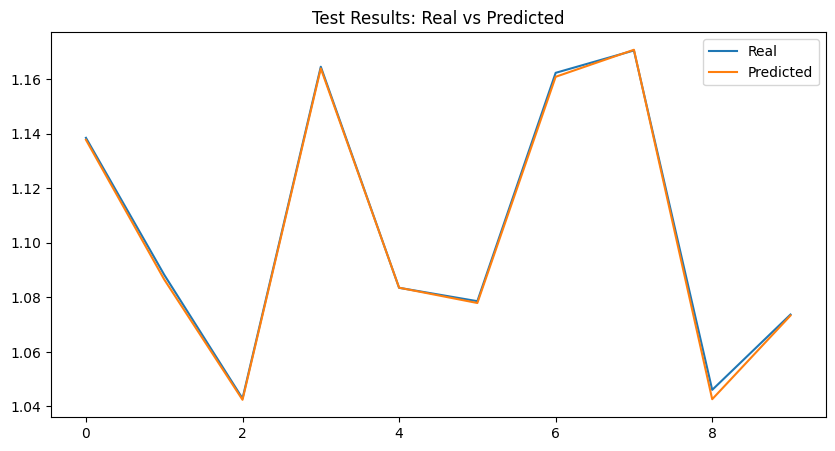

(120, 11)
Last Close 1.15878
Next predicted value: 1.1582091245471202
Next real value: 1.15981
Risidual: -0.0016008754528797908

=== Training with HIDDEN_SIZE=64, conv1_size=32, batch_size=16, num_layers=6 ===
Epoch 1/10, Loss: 0.24529
Epoch 2/10, Loss: 0.00153
Epoch 3/10, Loss: 0.00125
Epoch 4/10, Loss: 0.00100
Epoch 5/10, Loss: 0.00090
Epoch 6/10, Loss: 0.00083
Epoch 7/10, Loss: 0.00077
Epoch 8/10, Loss: 0.00073
Epoch 9/10, Loss: 0.00070
Epoch 10/10, Loss: 0.00065
Loss: 0.00049


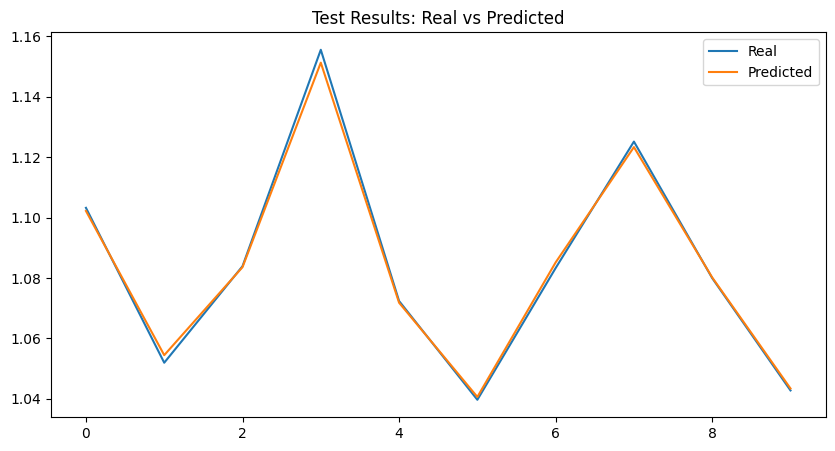

(120, 11)
Last Close 1.15878
Next predicted value: 1.1582837018584078
Next real value: 1.15981
Risidual: -0.0015262981415922194

=== Training with HIDDEN_SIZE=64, conv1_size=32, batch_size=32, num_layers=1 ===
Epoch 1/10, Loss: 0.00891
Epoch 2/10, Loss: 0.00052
Epoch 3/10, Loss: 0.00045
Epoch 4/10, Loss: 0.00043
Epoch 5/10, Loss: 0.00041
Epoch 6/10, Loss: 0.00041
Epoch 7/10, Loss: 0.00040
Epoch 8/10, Loss: 0.00040
Epoch 9/10, Loss: 0.00040
Epoch 10/10, Loss: 0.00039
Loss: 0.00038


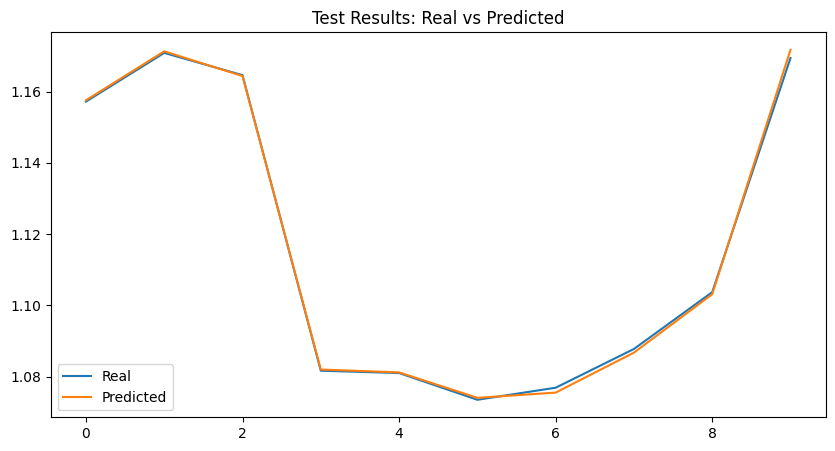

(120, 11)
Last Close 1.15878
Next predicted value: 1.1591243011443166
Next real value: 1.15981
Risidual: -0.0006856988556833699

=== Training with HIDDEN_SIZE=64, conv1_size=32, batch_size=32, num_layers=2 ===
Epoch 1/10, Loss: 0.02174
Epoch 2/10, Loss: 0.00057
Epoch 3/10, Loss: 0.00050
Epoch 4/10, Loss: 0.00047
Epoch 5/10, Loss: 0.00045
Epoch 6/10, Loss: 0.00044
Epoch 7/10, Loss: 0.00043
Epoch 8/10, Loss: 0.00042
Epoch 9/10, Loss: 0.00042
Epoch 10/10, Loss: 0.00042
Loss: 0.00051


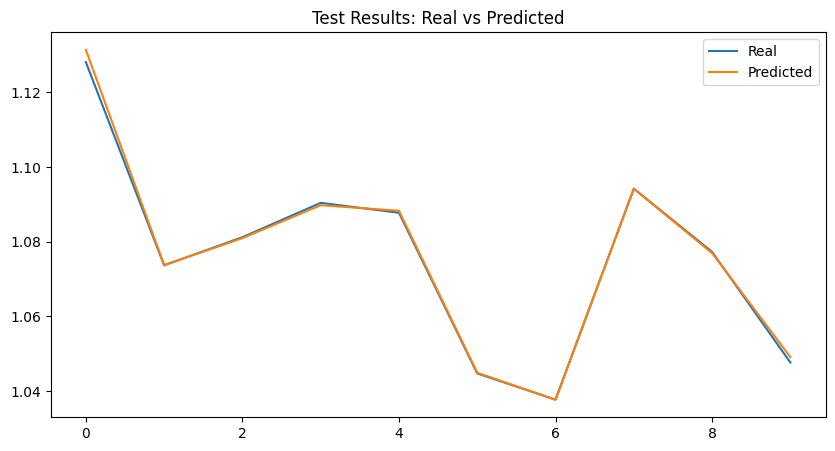

(120, 11)
Last Close 1.15878
Next predicted value: 1.1575348605304772
Next real value: 1.15981
Risidual: -0.0022751394695228466

=== Training with HIDDEN_SIZE=64, conv1_size=32, batch_size=32, num_layers=3 ===


In [ ]:
import itertools

TARGET_COL = 3
LOOKBACK = 120
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
HIDDEN_SIZE = 1024
CONV1_SIZE = 32
NUM_LAYERS = 1
OUTPUT_SIZE = 1
EPOCHS = 10

data = pd.DataFrame(columns=["last_close", "predict", "residual", "LOOKBACK"])
data.to_csv("result.csv", index=False)


batch = [8,16,32,64,128,256,512]
hidden = [64,128,256,512,1024]
conv = [32,64,128]
num_layers = [1,2,3,4,5,6]

for HIDDEN_SIZE, CONV1_SIZE, BATCH_SIZE, NUM_LAYERS in itertools.product(
    hidden, conv, batch, num_layers):
    print(f"\n=== Training with HIDDEN_SIZE={HIDDEN_SIZE}, conv1_size={CONV1_SIZE}, "
          f"batch_size={BATCH_SIZE}, num_layers={NUM_LAYERS} ===")
    df = pd.read_csv("EURH1.csv")
    df = df.tail(50000)
    target_value = df.iloc[-1, 5]  # no slice
    df = df.iloc[:len(df)-1, 2:]
    new_data = process(df,TARGET_COL,LOOKBACK,BATCH_SIZE,HIDDEN_SIZE,CONV1_SIZE,NUM_LAYERS,OUTPUT_SIZE,EPOCHS,target_value)
    data = pd.DataFrame([new_data])
    data.to_csv("result.csv", index=False,mode='a')